In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from preprocess import Audio_Processor
import classifiers
import feature_reduce
import time
import data_utils as du
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [3]:
path_to_db='../ESC-50/'
preprocess = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset.

In [4]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [5]:
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']

In [6]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


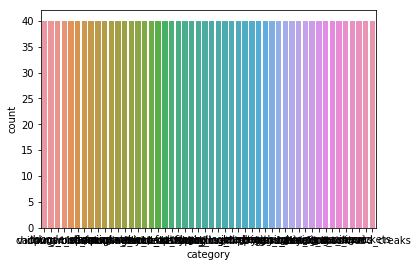

In [7]:
sns.countplot(dataset['category'])

## Preprocessing
Just MFCC were sufficient in previous work.
13 coefficients together with first and second derivatives and remove first energy component.
Should yield vector of 38 features per time frame.

In [8]:
test_file = pd.DataFrame(preprocess.preprocess('2-102414-A-17.wav'))

In [9]:
test_file.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,21.927575,20.290780,18.206072,16.158445,14.273799,12.354932,10.169572,7.719307,5.262192,3.099848,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
1,22.382184,21.468147,20.070725,18.335122,16.396533,14.348357,12.234242,10.065163,7.851280,5.631985,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
2,23.721630,22.750234,21.206390,19.194400,16.844600,14.300204,11.703585,9.183705,6.846216,4.767270,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
3,27.081467,25.569413,23.217595,20.250900,16.935373,13.542076,10.314547,7.444653,5.058995,3.215542,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119
4,27.904973,25.317398,21.752548,18.017817,14.759908,12.250736,10.353642,8.674094,6.814273,4.605797,...,-0.344654,-0.187106,-0.021905,0.098325,0.138104,0.10235,0.031212,-0.030292,-0.064038,-0.087119


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import pickle
def save_obj(obj, name ):
    with open('../preprocessed_objs/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('../preprocessed_objs/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def process_fold(fld):
    try:
        df = load_obj("fold_" + str(fld))
    except IOError:
        start_time = time.time()
        df = preprocess.preprocess_fold(fld, dataset, parallel=False)
        print("\tBytes: " + str(df.memory_usage(index=True).sum()))
        print("\tProcessing Time: " + str(time.time() - start_time))
        save_obj(df, "fold_" + str(fld))
    return df

In [11]:
c_data = pd.concat([process_fold(fld) for fld in range(1,6)], ignore_index=True)

In [12]:
c_data.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCCp2_4,MFCCp2_5,MFCCp2_6,MFCCp2_7,MFCCp2_8,MFCCp2_9,MFCCp2_10,MFCCp2_11,MFCCp2_12,target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0


In [13]:
n_categories = c_data.target.unique().size

In [14]:
c_data, scalar = du.normalize_data(c_data, 'target')

In [15]:
train, test = du.split_training_test(c_data, 0.2)
train_X = train.drop(columns=['target'])
train_y = train.target

## Overall GMM
Train GMM for all categories over frames in preprocessed data

In [16]:
clas = load_obj('trained_overall_gmm')

In [ ]:
clas = classifiers.cpu_train('gmm', n_categories, train_X)

Initialization 0


In [ ]:
save_obj(clas, 'trained_overall_gmm')

In [ ]:
test_X = test.drop(columns=['target'])
test_y = test.target
metrics.precision_recall_fscore_support(test_y, list(clas.predict(test_X)))

## Specific GMM
Train a specific GMM for categories

In [ ]:
spec_gmm = load_obj('trained_specific_gmm')

In [ ]:
spec_gmm = {}
for cat in range(0,50):
    train, test = du.split_training_test(c_data[c_data['target'] == cat], 0.2)
    train_X = train.drop(columns=['target'])
    train_y = train.target
    spec_gmm[classes[cat]] = classifiers.cpu_train_gmm_preinitialize(clas, train_X, train_y)

In [ ]:
save_obj(clas, 'trained_specific_gmm')

## Scoring
Here we get the log likelihood of the categories when matched with its training data

In [19]:
from classification_plots import plot_confusion_matrix
cm = metrics.confusion_matrix(test_y, list(clas.predict(test_X)))

Confusion matrix, without normalization
[[ 0  2 13 ...  0 21  0]
 [ 0  7 29 ... 14 46  0]
 [ 0  0 33 ... 14 62  0]
 ...
 [ 0  0  3 ...  6 11  0]
 [38  4  8 ... 62  6  0]
 [ 0  0  0 ...  1  0  0]]


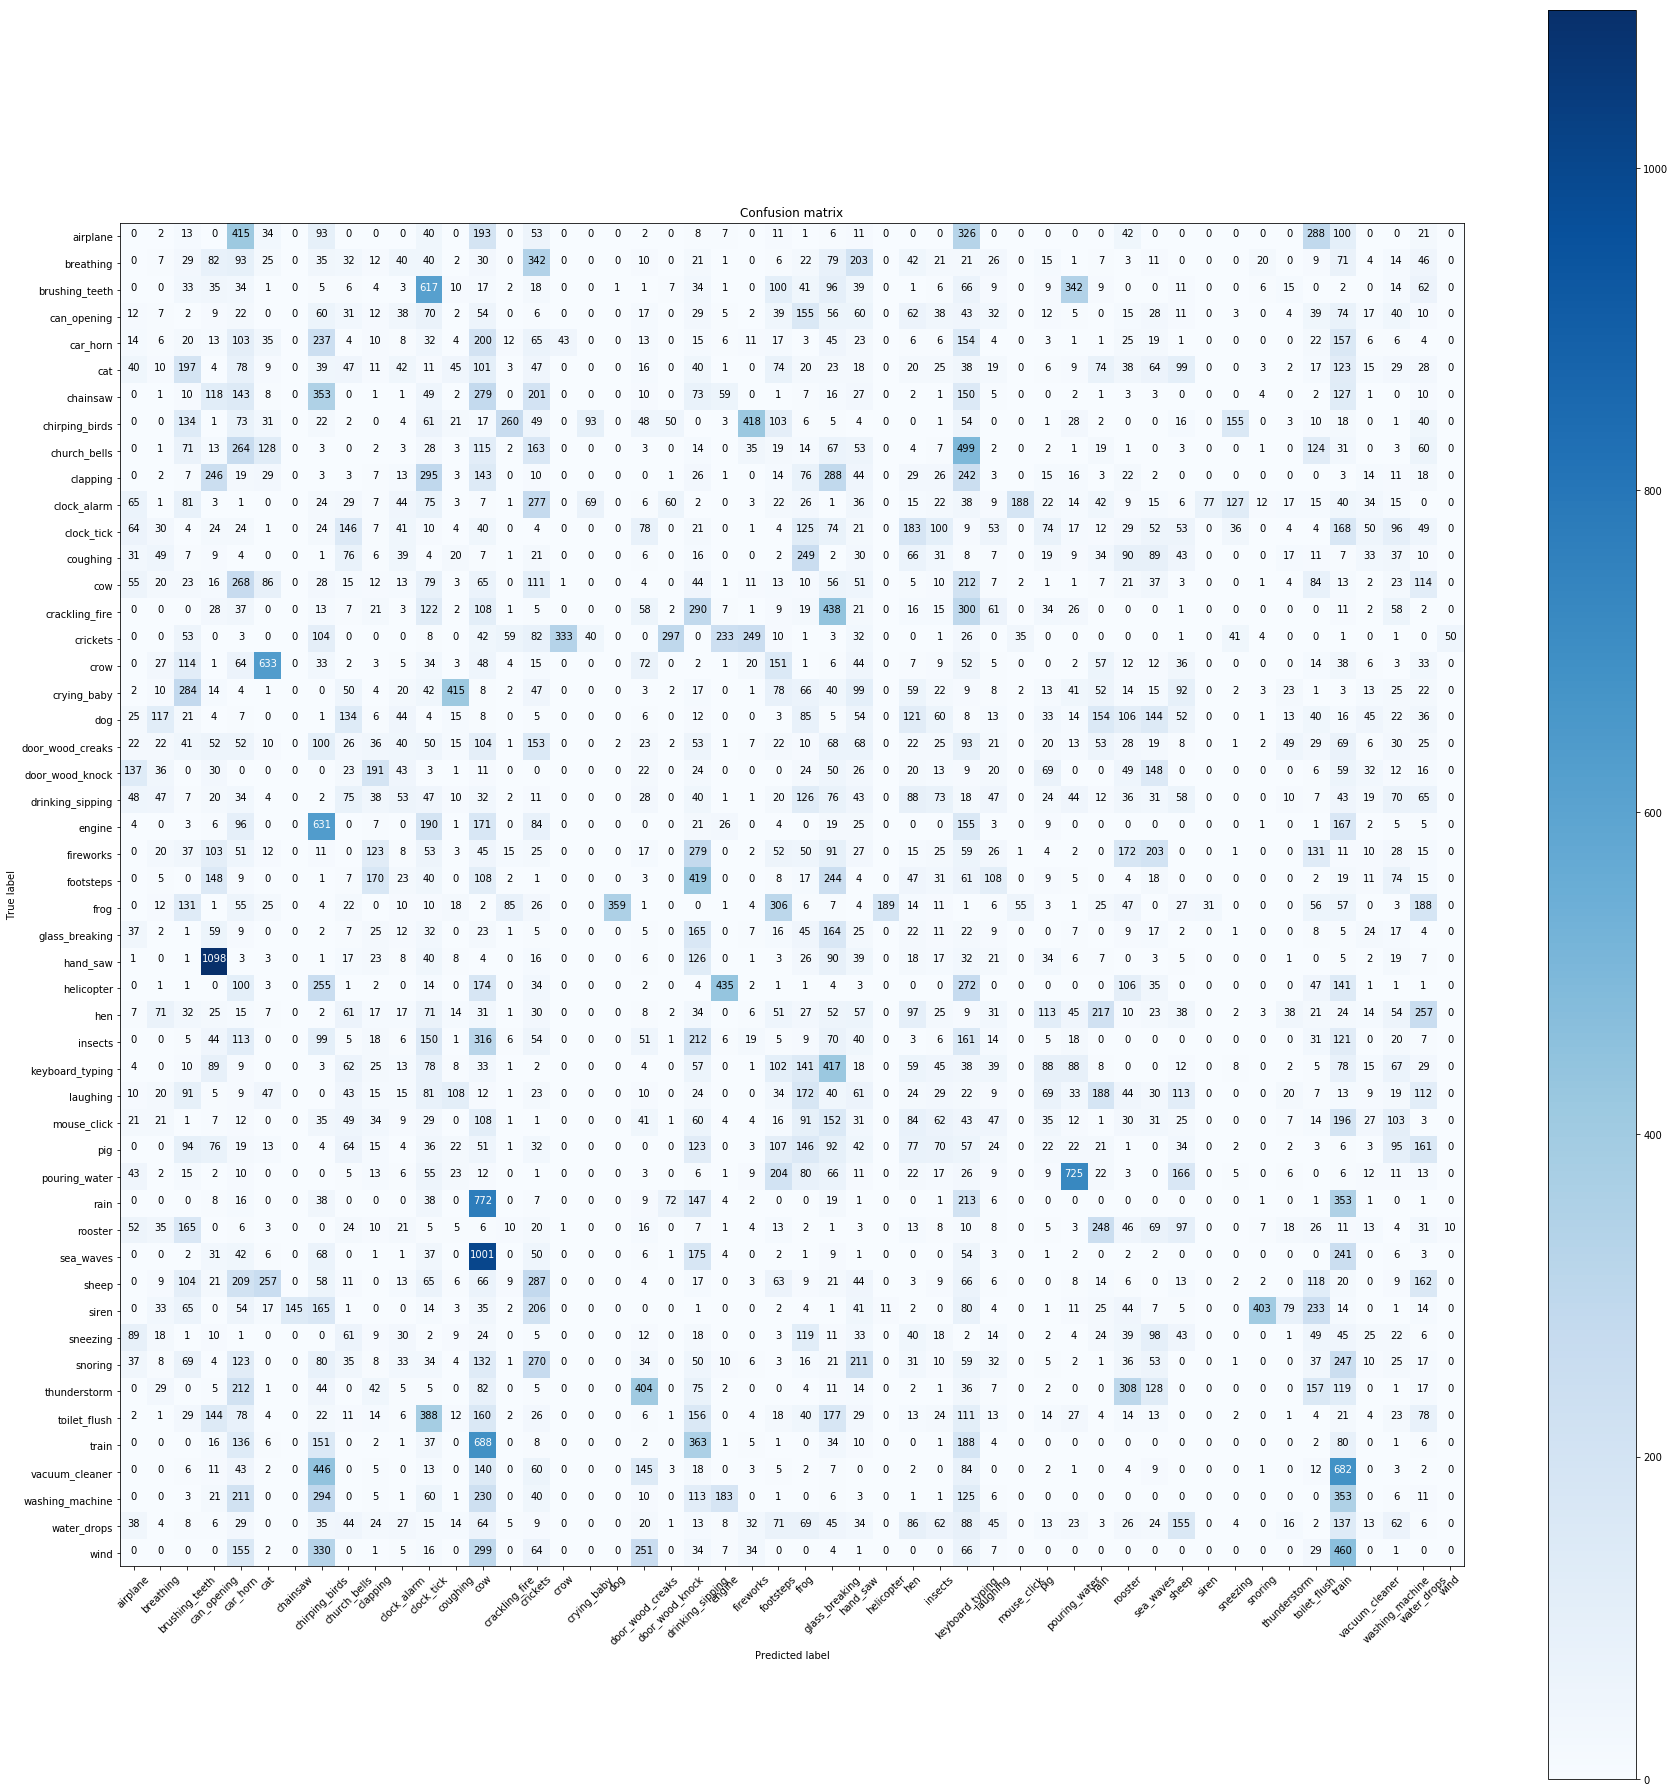

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
plot_confusion_matrix(cm, classes)

## Basic Probability of File Category
We run our classifier over the file's audio frames and use basic averages to determine the probability of it belonging to a class. (Should in future have classifier give probability scores for each category for each frame but... thats future work)

In [36]:
from collections import Counter
def file_probability(filename, clas, preprocessor, class_list):
    test_file = pd.DataFrame(preprocessor.preprocess(filename))
    predictions = [class_list[i] for i in list(clas.predict(test_file))]
    sns.countplot(predictions)
    c = Counter(predictions)
    return [(i, c[i] / len(predictions) * 100.0) for i, count in c.most_common()]

In [41]:
plt.figure(figsize=(10,10))
file = dataset.filename.sample(n=1).values[0]
file_probability(file, clas, preprocess, classes)

[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 

<Figure size 720x720 with 0 Axes>

In [38]:
dataset[dataset.filename == file]

,filename,fold,target,category,esc10,src_file,take
837,3-110913-C-7.wav,3,7,insects,False,110913,C
